<h1><center>MNIST classification using Numpy<center></h1>

### By Daniel Deutsch and Kevin Kühl

## Importing Numpy and Keras

In [1]:
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt

print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 2.4.1
Using keras version 2.4.3


In [2]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

## Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets. Check the size of the training and testing sets. 

In [3]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
# START CODE HERE
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(f"X_train size: {train_images.shape[0]} samples")
print(f"y_train size: {train_labels.shape[0]} samples")
print(f"X_test size: {test_images.shape[0]} samples")
print(f"y_test size: {test_labels.shape[0]} samples")
# END CODE HERE


X_train size: 60000 samples
y_train size: 60000 samples
X_test size: 10000 samples
y_test size: 10000 samples


The MNIST database contains 60,000 training images and 10,000 testing images.
Using the pyplot package, visualize the first sample of the training set:

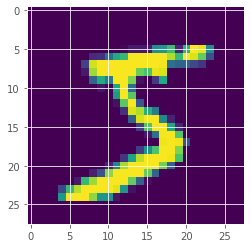

In [4]:
# Let us visualize the first training sample using the Matplotlib library
from matplotlib import pyplot as plt
# START CODE HERE
plt.imshow(train_images[0])
plt.show()
# END CODE HERE

The database contains images of handwritten digits. Hence, they belong to one of 10 categories, depending on the digit they represent. 
Reminder: in order to do multi-class classification, we use the softmax function, which outputs a multinomial probability distribution. That means that the output to our model will be a vector of size $10$, containing probabilities (meaning that the elements of the vector will be positive sum to $1$).
For easy computation, we want to true labels to be represented with the same format: that is what we call **one-hot encoding**. For example, if an image $\mathbf{x}$ represents the digit $5$, we have the corresponding one_hot label (careful, $0$ will be the first digit): 
$$ \mathbf{y} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] $$
Here, you need to turn train and test labels to one-hot encoding using the following function: 

In [5]:
from keras.utils.np_utils import to_categorical
# START CODE HERE
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
# END CODE HERE

Images are black and white, with size $28 \times 28$. We will work with them using a simple linear classification model, meaning that we will have them as vectors of size $(784)$.
You should then transform the images to the size $(784)$ using the numpy function ```reshape```.

Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation. Be careful to your methodology: while you have access to training data, you may not have access to testing data, and must avoid using any statistic on the testing dataset.

In [6]:
# Reshape to proper images with 1 color channel according to backend scheme
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images = train_images.reshape((train_images.shape[0], img_rows*img_cols))
# START CODE HERE
test_images = test_images.reshape((test_images.shape[0], img_rows*img_cols))
# END CODE HERE

# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
# START CODE HERE

mean = np.mean(train_images)
std = np.std(train_images) + 1e-7

train_images = (train_images - mean)/std
test_images = (test_images - mean)/std
# END CODE HERE

# Working with Numpy

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf) for some basic information on how to use numpy.

## Defining the model 

We will here create a simple, linear classification model. We will take each pixel in the image as an input feature (making the size of the input to be $784$) and transform these features with a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$. Since there is $10$ possible classes, we want to obtain $10$ scores. Then, 
$$ \mathbf{W} \in \mathbb{R}^{784 \times 10} $$
$$ \mathbf{b} \in \mathbb{R}^{10} $$

and our scores are obtained with:
$$ \mathbf{z} = \mathbf{W}^{T} \mathbf{x} +  \mathbf{b} $$

where $\mathbf{x} \in \mathbb{R}^{784}$ is the input vector representing an image.
We note $\mathbf{y} \in \mathbb{R}^{10}$ as the target one_hot vector. 

Here, you fist need to initialize $\mathbf{W}$ and $\mathbf{b}$ using ```np.random.normal``` and ```np.zeros```, then compute $\mathbf{z}$.

In [7]:
# To avoid implementing a complicated gradient back-propagation,
# we will try a very simple architecture with one layer 
def initLayer(n_input,n_output):
    """
    Initialize the weights, return the number of parameters
    Inputs: n_input: the number of input units - int
          : n_output: the number of output units - int
    Outputs: W: a matrix of weights for the layer - numpy ndarray
           : b: a vector bias for the layer - numpy ndarray
           : nb_params: the number of parameters  - int
    """
    # START CODE HERE
    W = np.random.normal(size=(n_input,n_output))
    b = np.zeros((n_output,1))
    nb_params = n_input*n_output + n_output
    # END CODE HERE
    return W, b, nb_params

In [8]:
n_training = train_images.shape[0] 
n_feature = train_images.shape[1]
n_labels = 10
W, b, nb_params = initLayer(n_feature, n_labels)

In [9]:
def forward(W, b, X):
    """
    Perform the forward propagation
    Inputs: W: the weights - numpy ndarray
          : b: the bias - numpy ndarray
          : X: the batch - numpy ndarray
    Outputs: z: outputs - numpy ndarray
    """
    X = np.matrix(X).T
    W = np.matrix(W)
    b = np.matrix(b)
    z = np.dot(W.T, X) + b
    return z

## Computing the output 

To obtain classification probabilities, we use the softmax function:
$$ \mathbf{o} = softmax(\mathbf{z}) \text{         with          } o_i = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)} $$

The usual difficulty with the softmax function is the possibility of overflow when the scores $z_i$ are already large. Since a softmax is not affected by a shift affecting the whole vector $\mathbf{z}$:
$$ \frac{\exp(z_i - c)}{\sum_{j=0}^{9} \exp(z_j - c)} =  \frac{\exp(c) \exp(z_i)}{\exp(c) \sum_{j=0}^{9} \exp(z_j)} = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)}$$
what trick can we use to ensure we will not encounter any overflow ? 

In [10]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - numpy ndarray
    Outputs: out: the activation values - numpy ndarray
    """
    out = np.divide(np.exp(z - np.max(z)), np.sum(np.exp(z - np.max(z)), axis=0))
    return out

## Making updates

We define a learning rate $\eta$. The goal is to be able to apply updates:
$$ \mathbf{W}^{t+1} = \mathbf{W}^{t} - \nabla_{\mathbf{W}} l_{ML} $$

In order to do this, we will compute this gradient (and the bias) in the function ```update```. In the next function ```updateParams```, we will actually apply the update with regularization. 

Reminder: the gradient $\nabla_{\mathbf{W}} l_{ML}$ is the matrix containing the partial derivatives 
$$ \left[\frac{\delta l_{ML}}{\delta W_{ij}}\right]_{i=1..784, j=1..10} $$


Coordinate by coordinate, we obtain the following update: 
$$ W_{ij}^{t+1} = W_{ij}^{t} - \frac{\delta l_{ML}}{\delta W_{ij}} $$

Via the chain rule, we obtain, for an input feature $i \in [0, 783]$ and a output class $j \in [0, 9]$: $$\frac{\delta l_{ML}}{\delta W_{ij}} = \frac{\delta l_{ML}}{\delta z_{j}} \frac{\delta z_j}{\delta W_{ij}}$$ 

It's easy to compute that $\frac{\delta z_j}{\delta W_{ij}} = x_i$

We compute the softmax derivative, to obtain:
$$ \nabla_{\mathbf{z}} l_{ML} = \mathbf{o} - \mathbf{y} $$

Hence, $\frac{\delta l_{ML}}{\delta z_{j}} = o_j - y_j$ and we obtain that $$\frac{\delta l_{ML}}{\delta W_{ij}} = (o_j - y_j) x_i$$

This can easily be written as a scalar product, and a similar computation (even easier, actually) can be done for $\mathbf{b}$. Noting $\nabla_{\mathbf{z}} l_{ML} = \mathbf{o} - \mathbf{y}$ as ```grad``` in the following function, compute the gradients $\nabla_{\mathbf{W}} l_{ML}$ and $\nabla_{\mathbf{b}} l_{ML}$ in order to call the function ```updateParams```.

Note: the regularizer and the weight_decay $\lambda$ are used in ```updateParams```.

In [11]:
def update(eta, W, b, grad, X, regularizer, weight_decay):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : W: the weights - ndarray
          : b: the bias -  ndarray
          : grad: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : X: the data -  ndarray
          : regularizer: 'L2' or None - the regularizer to be used in updateParams
          : weight_decay: the weight decay to be used in updateParams - float
    Outputs: W: the weights updated -  ndarray
           : b: the bias updated -  ndarray
    """
    grad_w = np.dot(np.matrix(grad),np.matrix(X))
    grad_b = grad.T
    W = updateParams(W, grad_w, eta, regularizer, weight_decay)
    b = updateParams(b, grad_b, eta, regularizer, weight_decay)
    return W, b

The update rule is affected by regularization. We implement two cases: No regularization, or L2 regularization. Use the two possible update rules to implement the following function:

In [12]:
def updateParams(param, grad_param, eta, regularizer=None, weight_decay=0.):
    """
    Perform the update of the parameters
    Inputs: param: the network parameters - ndarray
          : grad_param: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : weight_decay: the weight-decay - float
    Outputs: the parameters updated - ndarray
    """
    if regularizer==None:
        return param - eta*grad_param
    elif regularizer=='L2':
        return  param - eta*grad_param.T - 2*weight_decay*param
    else:
        raise NotImplementedError

## Computing the Accuracy

Here, we simply use the model to predict the class (by taking the argmax of the output !) for every example in ```X```, and count the number of times the model is right, to output the accuracy.

In [13]:
def computeAcc(W, b, X, labels):
    """
    Compute the loss value of the current network on the full batch
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
           : accuracy: the ratio of examples that are well-classified - float
    """ 
    ### Forward propagation
    z = forward(W, b, X)
 
    ### Compute the softmax and the prediction
    out = softmax(z)
    pred = np.argmax(z, axis=0)
    answer = np.argmax(labels, axis=1)
    ### Compute the accuracy
    accuracy = np.mean(pred==answer)

    return accuracy 

## Preparing training

The following hyperparameters are given. Next, we can assemble all the function previously defined to implement a training loop. We will train the classifier on **one epoch**, meaning that the model will see each trainin example once. 

In [14]:
# Optimization
eta = 0.01
regularizer = 'L2'
weight_decay = 0.0001

# Training
log_interval = 3000

In [15]:
# Data structures for plotting
g_train_acc=[]
g_valid_acc=[]

#######################
### Learning process ##
#######################
for j in range(n_training):

    ### Getting the example
    X, y = train_images[j], train_labels[j]
    y = np.matrix(y).T

    ### Forward propagation
    z = forward(W,b,X)

    ### Compute the softmax
    out = softmax(z)
    ### Compute the gradient at the top layer
    derror = out - y # This is o - y 

    ### Update the parameters
    W, b = update(eta, W, b, derror, X, regularizer, weight_decay)

    if j % log_interval == 0:
        ### Every log_interval examples, look at the training accuracy
        train_accuracy = computeAcc(W, b, train_images, train_labels) 

        ### And the testing accuracy
        test_accuracy = computeAcc(W, b, test_images, test_labels) 

        g_train_acc.append(train_accuracy)
        g_valid_acc.append(test_accuracy)


        result_line = f"{j} - Train: {train_accuracy:.3f} Test: {test_accuracy:.3f} Eta: {eta}"
        print(result_line)

g_train_acc.append(train_accuracy)
g_valid_acc.append(test_accuracy)
result_line = f"Final result - Train: {train_accuracy:.3f} Test: {test_accuracy:.3f} Eta: {eta}"
print(result_line)     

0 - Train: 0.073 Test: 0.076 Eta: 0.01
3000 - Train: 0.800 Test: 0.813 Eta: 0.01
6000 - Train: 0.828 Test: 0.835 Eta: 0.01
9000 - Train: 0.813 Test: 0.816 Eta: 0.01
12000 - Train: 0.791 Test: 0.801 Eta: 0.01
15000 - Train: 0.832 Test: 0.837 Eta: 0.01
18000 - Train: 0.825 Test: 0.828 Eta: 0.01
21000 - Train: 0.789 Test: 0.798 Eta: 0.01
24000 - Train: 0.828 Test: 0.836 Eta: 0.01
27000 - Train: 0.831 Test: 0.839 Eta: 0.01
30000 - Train: 0.794 Test: 0.796 Eta: 0.01
33000 - Train: 0.798 Test: 0.803 Eta: 0.01
36000 - Train: 0.752 Test: 0.758 Eta: 0.01
39000 - Train: 0.830 Test: 0.830 Eta: 0.01
42000 - Train: 0.799 Test: 0.799 Eta: 0.01
45000 - Train: 0.851 Test: 0.855 Eta: 0.01
48000 - Train: 0.834 Test: 0.838 Eta: 0.01
51000 - Train: 0.838 Test: 0.845 Eta: 0.01
54000 - Train: 0.763 Test: 0.771 Eta: 0.01
57000 - Train: 0.809 Test: 0.821 Eta: 0.01
Final result - Train: 0.809 Test: 0.821 Eta: 0.01


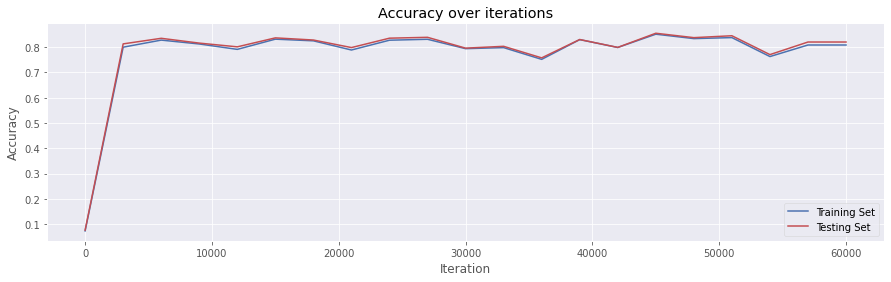

In [16]:
# Print the accuracy as a performance measure
x = np.arange(len(g_train_acc))*log_interval

plt.plot(x, g_train_acc, label='Training Set')
plt.plot(x, g_valid_acc, label='Testing Set')

plt.title('Accuracy over iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
print(f"Best accuracy for training set: {np.max(g_train_acc)} in iteration {np.argmax(g_train_acc)*log_interval}")
print(f"Best accuracy for test set: {np.max(g_valid_acc)} in iteration {np.argmax(g_valid_acc)*log_interval}")

print(f"Average accuracy for training set: {np.mean(g_train_acc)}")
print(f"Average accuracy for test set: {np.mean(g_valid_acc)}")

Best accuracy for training set: 0.8514166666666667 in iteration 45000
Best accuracy for test set: 0.8552 in iteration 45000
Average accuracy for training set: 0.7755746031746032
Average accuracy for test set: 0.7818047619047619


What can you say about the performance of this simple linear classifier ? 

According to our results, an important thing to be noticed is the lack of evidence for overfitting, as we have obtained similar accuracy for both train and test datasets.

Also, we tried to vary the learning rate between the range ($10^{-3},10^{1}$), but without obtaining significant changes in our results.

The overall accuracy was 77.5% for the training set and 78.1% for the test set. The best accuracy considering all the iterations was 85.1% for the training set and 85.52% for the test set, occuring at iteration 45000.